In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import tltorch
import copy
from tddl.trainer import Trainer
from tddl.models.cnn import TdNet
from tddl.utils.prime_factors import get_prime_factors



In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
if 0.3:
    print('YEeey')
else:
    print('Neeehh')

YEeey


In [143]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [194]:
batch_size = 1024

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset = datasets.MNIST('/bigdata/mnist', train=True, download=True, transform=transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, (50000, 10000), generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('/bigdata/mnist', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [145]:
dataiter = iter(train_loader)

In [146]:
images, labels = dataiter.next()

In [7]:
img_grid = torchvision.utils.make_grid(images)

In [29]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.3081 + 0.1307     # unnormalize
    if type(img) == torch.Tensor:
        npimg = img.numpy()
    else:
        npimg = img
    if one_channel:
        plt.imshow(img, cmap="Greys")
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))

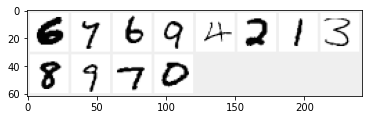

In [30]:
matplotlib_imshow(img_grid, one_channel=True)

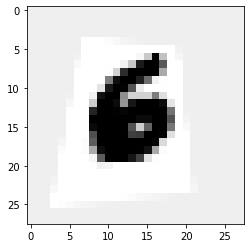

In [42]:
matplotlib_imshow(perspective_transformer(orig_img), one_channel=True)

In [31]:
orig_img = images[0]



In [32]:
perspective_transformer = T.RandomPerspective(distortion_scale=0.9, p=1.0)
perspective_imgs = np.array([perspective_transformer(orig_img) for _ in range(4)])
matplotlib_imshow(perspective_imgs)

<ipython-input-32-1488d977fa67>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  perspective_imgs = np.array([perspective_transformer(orig_img) for _ in range(4)])
<ipython-input-32-1488d977fa67>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  perspective_imgs = np.array([perspective_transformer(orig_img) for _ in range(4)])


ValueError: axes don't match array

In [ ]:
RandomPerspective
RandomRotation
RandomAffine
RandomResizedCrop

torchvision.transforms.Lambda(lambda x: x + torch.randn_like(x))

In [58]:
rotater = T.RandomRotation(degrees=(-30, 30))

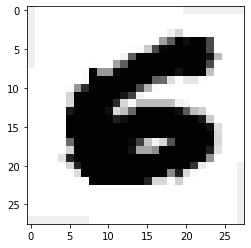

In [92]:
matplotlib_imshow(rotater(orig_img), one_channel=True)

In [2]:
model = torch.load("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/mnist/cnn-32-32_bn_256_adam_l0.01_g0.9/1628155584/cnn_best")


In [3]:
print(model)

AttributeError: 'Net' object has no attribute 'summary'

In [149]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
       BatchNorm2d-3           [-1, 32, 24, 24]              64
           Dropout-4           [-1, 32, 12, 12]               0
            Linear-5                  [-1, 128]         589,952
       BatchNorm1d-6                  [-1, 128]             256
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 601,130
Trainable params: 601,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 2.29
Estimated Total Size (MB): 2.78
----------------------------------------------------------------


In [10]:
print(f"{[0, 1]}")

[0, 1]


In [204]:
rank = 0.75
decompose_weights = True
factorization = 'tt'

In [186]:
print(model.fc1.in_features)
get_prime_factors(model.fc1.in_features)

4608


(2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3)

In [205]:
fact_model = copy.deepcopy(model)


In [206]:

# fact_model.conv1 = tltorch.FactorizedConv.from_conv(model.conv1, rank=rank, decompose_weights=decompose_weights, factorization=factorization)
fact_model.conv2 = tltorch.FactorizedConv.from_conv(model.conv2, rank=rank, decompose_weights=decompose_weights, factorization=factorization)
fact_model.fc1 = tltorch.FactorizedLinear.from_linear(
    model.fc1, 
    in_tensorized_features=get_prime_factors(model.fc1.in_features), 
    out_tensorized_features=get_prime_factors(model.fc1.out_features), 
    rank=rank, 
    # decompose_weights=decompose_weights, 
    factorization=factorization,
)
# fact_model.fc2 = tltorch.FactorizedLinear.from_linear(model.fc2, rank=rank, decompose_weights=decompose_weights, factorization=factorization)


In [207]:
fact_model.cuda()
fact_model(images.cuda())

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tltorch/tensor_factorizations/core.py:484: UserWarning: TTTensorized, shape=(128, 4608), tensorized_row_shape=(2, 2, 2, 2, 2, 2, 2),  tensorized_column_shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3), rank=[1, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 138, 166, 1], ) is being reconstructed into a matrix, consider operating on the decomposed form.
  warnings.warn(f'{self} is being reconstructed into a matrix, consider operating on the decomposed form.')


tensor([[-1.3833e+01, -2.3435e+01, -2.3286e+01, -2.2324e+01, -2.3049e+01,
         -1.3875e+01, -1.9073e-06, -3.4366e+01, -1.8297e+01, -2.2221e+01],
        [-2.2929e+01, -1.1551e+01, -1.8189e+01, -1.3008e+01, -2.0193e+01,
         -1.8274e+01, -2.7295e+01, -1.5616e-05, -1.4746e+01, -1.2592e+01],
        [-2.9814e+01, -3.2724e+01, -2.4248e+01, -4.1556e+01, -3.2956e+01,
         -2.7333e+01,  0.0000e+00, -4.3337e+01, -3.0347e+01, -3.9526e+01],
        [-3.3873e+01, -3.6391e+01, -3.2150e+01, -2.4055e+01, -1.9633e+01,
         -3.2342e+01, -3.8218e+01, -2.0352e+01, -2.4728e+01,  0.0000e+00],
        [-2.1473e+01, -1.7247e+01, -1.7263e+01, -2.6358e+01,  0.0000e+00,
         -2.3892e+01, -1.9589e+01, -1.9319e+01, -2.6488e+01, -2.0788e+01],
        [-3.2212e+01, -2.7965e+01,  0.0000e+00, -3.9403e+01, -3.2268e+01,
         -4.9557e+01, -4.1662e+01, -2.5404e+01, -4.4886e+01, -4.3046e+01],
        [-3.1888e+01,  0.0000e+00, -3.4170e+01, -3.1180e+01, -2.9347e+01,
         -2.8211e+01, -2.2384e+0

In [210]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [209]:
layers = []
for i, (name, module) in enumerate(model.named_modules()):
    print(type(module))
    if i == 2:
        if type(module) == torch.nn.modules.conv.Conv2d:
            fact_layer = tltorch.FactorizedConv.from_conv(module, rank=rank, decompose_weights=decompose_weights, factorization=factorization)
        fact_model._modules[name] = fact_layer



<class 'tddl.models.cnn.Net'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.batchnorm.BatchNorm1d'>
<class 'torch.nn.modules.linear.Linear'>


/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [132]:
for i, layer in enumerate(model.named_modules()):
    print(layer)

('', Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
))
('conv1', Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)))
('conv2', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)))
('conv2_bn', BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('dropout1', Dropout(p=0.25, inplace=False))
('dropout2', Dropout(p=0.5, inplace=False))
('fc1', Linear(in_features=4608, out_features=128, bias=True))
('fc1_bn', BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('fc2'

In [123]:
layers

[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
 FactorizedConv(
   in_channels=32, out_channels=32, kernel_size=(3, 3), rank=66, order=2, 
   (weight): CPTensor(shape=(32, 32, 3, 3), rank=66)
 ),
 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout(p=0.25, inplace=False),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4608, out_features=128, bias=True),
 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=128, out_features=10, bias=True)]

In [200]:
summary(fact_model, (1,28,28))

IndexError: tuple index out of range

In [140]:
fact_model(images[0][None,:].cuda())

IndexError: tuple index out of range

In [160]:
print(fact_model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): FactorizedConv(
    in_channels=32, out_channels=32, kernel_size=(3, 3), rank=99, order=2, 
    (weight): CPTensor(shape=(32, 32, 3, 3), rank=99)
  )
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [2]:
batch_size = 1024

transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])

dataset = datasets.MNIST('/bigdata/mnist', train=True, download=True, transform=transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, (50000, 10000), generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [208]:
trainer = Trainer(train_loader, valid_loader, fact_model, optimizer=None, writer=None, scheduler=None, save=None)
acc_train = trainer.test(train_loader)
acc_valid = trainer.test(valid_loader)


100%|██████████| 10/10 [00:00<00:00, 12.14it/s]


In [3]:
td_model = TdNet()

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [4]:
trainer = Trainer(train_loader, valid_loader, td_model, optimizer=None, writer=None, scheduler=None, save=None)
acc_train = trainer.test(train_loader)
acc_valid = trainer.test(valid_loader)

  0%|          | 0/49 [00:00<?, ?it/s]/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tltorch/tensor_factorizations/core.py:484: UserWarning: TuckerMatrix, shape=(128, 4608), tensorized_row_shape=(2, 2, 2, 2, 2, 2, 2),  tensorized_column_shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3), rank=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], ) is being reconstructed into a matrix, consider operating on the decomposed form.
  warnings.warn(f'{self} is being reconstructed into a matrix, consider operating on the decomposed form.')
100%|██████████| 10/10 [00:00<00:00, 11.88it/s]
